Full Notebook

In [1]:
# Wine Data Set

In [2]:
import time
start_time = time.time()
from qiskit_ibm_provider import IBMProvider
provider = IBMProvider()

# Standard imports
import numpy as np
import pandas as pd
import time
import warnings

# Qiskit 
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, ADAM, SLSQP, AQGD
from qiskit_algorithms.utils import algorithm_globals

# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns
from qiskit.visualization import plot_histogram
from IPython.display import clear_output

# Machine learning and preprocessing
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

In [3]:
from sklearn.datasets import load_wine
wine_data = load_wine()
features = wine_data.data
labels = wine_data.target
features = MinMaxScaler().fit_transform(features)
algorithm_globals.random_seed = 4701

wine_train_features, wine_test_features, wine_train_labels, wine_test_labels = train_test_split(
    features, labels, train_size = 0.8, random_state = algorithm_globals.random_seed)
num_features = features.shape[1]

In [4]:
sampler = Sampler()
optimizer=COBYLA(maxiter=100)
ansatz = EfficientSU2(num_qubits=num_features, reps = 3)
feature_map = ZZFeatureMap(feature_dimension=num_features, reps =1 )

In [5]:
objective_func_vals = []
plt.rcParams['figure.figsize'] = (12,6)

def callback_graph(weights, obj_func_eval):
             
             clear_output(wait=True)
             objective_func_vals.append(obj_func_eval)
             plt.title('Objective function value against Iteration EFF Ansatz')
             plt.xlabel('Iteration')
             plt.ylabel('Objective function value')
             plt.plot(range(len(objective_func_vals)), objective_func_vals)
             
             plt.show()

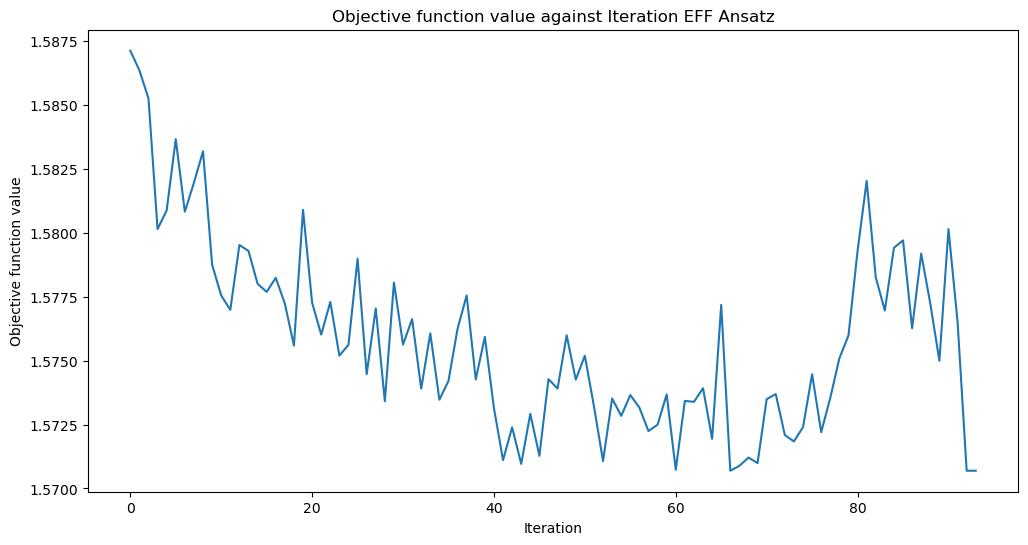

In [ ]:
wine_vqc = VQC(
    sampler = sampler, 
    feature_map = feature_map,
    ansatz = ansatz, 
    optimizer = optimizer, 
    callback = callback_graph,)

objective_func_vals = []

start = time.time()
wine_vqc.fit(wine_train_features,wine_train_labels)
elsapsed_time = time.time() - start 

print(f'Training time: {elsapsed_time}')

In [ ]:
wine_vqc.save('quantum_classifiers/wine_vqc.model')

In [ ]:
# Leave One Out 

In [ ]:
objective_func_vals = []



plt.rcParams['figure.figsize'] = (12,6)

def loo_callback_graph(weights, obj_func_eval):
    global current_dataset
    clear_output(wait=True)
    objective_func_vals_dict[current_dataset].append(obj_func_eval)
    plt.title("Objective function value against Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    
    for description, obj_vals in objective_func_vals_dict.items():
        if obj_vals:  # Plot only if there are values
            iterations = range(len(obj_vals))
            plt.plot(iterations, obj_vals, label=description)
            # Annotate the most recent point
            plt.annotate(f"{obj_vals[-1]:.2f}",
                         (iterations[-1], obj_vals[-1]),
                         textcoords="offset points",
                         xytext=(0,10),
                         ha='center',
                         fontsize=8)

    plt.legend()
    plt.show()


In [ ]:
full_features = wine_data.data
feature_names = [
    'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
    'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins',
    'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline'
]

data_descriptions = ["Full Features"] + [f"Missing {feature.replace('_', ' ').title()}" for feature in feature_names]


In [ ]:
training_times = {}
vqc_scores = {}
plt.clf()
objective_func_vals_dict = {
    "Full Features": [],
    "Missing  alcohol": [],
    "Missing  malic_acid": [],
    "Missing  ash": [],
    "Missing  alcalinity_of_ash": [],
    "Missing  magnesium": [],
    "Missing  total_phenols": [],
    "Missing  flavanoids": [],
    "Missing  nonflavanoid_phenols": [],
    "Missing  proanthocyanins": [],
    "Missing  color_intensity": [],
    "Missing  hue": [],
    "Missing  od280/od315_of_diluted_wines": [],
    "Missing  proline": []
    
}

for i, description in enumerate(data_descriptions):
    features = full_features 
    if i == 0:
        features = features 
    else:
        features = np.delete(features, i-1, axis = 1)
    
    num_features = features.shape[1]  
    current_dataset = description
    

    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = EfficientSU2(num_qubits=num_features, reps=3)
    
    

    features_scaled = MinMaxScaler().fit_transform(features)
    train_features, test_features, train_labels, test_labels = train_test_split(
        features_scaled, labels, train_size=0.8, random_state=algorithm_globals.random_seed)
    

    vqc = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=loo_callback_graph
    )

    start_time = time.time()
    vqc.fit(train_features, train_labels)
    elapsed_time = time.time() - start_time
    

    test_score_quantum = vqc.score(test_features, test_labels)
    vqc_scores[description] = {'Training Score': train_score_quantum, 'Test Score': test_score_quantum}


    training_times[description] = elapsed_time
    print(f"Training time: {elapsed_time:.2f} seconds")

In [ ]:
full_feature_test_score = vqc_scores['Full Features']['Test Score']

abs_differences = {desc: vqc_scores[desc]['Test Score'] - full_feature_test_score 
                   for desc in vqc_scores if desc != "Full Features"}

data = []
for description, scores in vqc_scores.items():
    test_score = scores['Test Score']
    difference = test_score - full_feature_test_score
    difference_percentage = (difference / full_feature_test_score) * 100 if full_feature_test_score else 0
    data.append({"Description": description, 
                 "Test Score": test_score, 
                 "Difference from Full Features": difference,
                 "Percentage Difference from Full Features": difference_percentage})

loo_scores_df = pd.DataFrame(data)

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(descriptions, diff_values, color='blue')
plt.xlabel('Configuration')
plt.ylabel('Difference in Test Accuracy from Full Features')
plt.title('Impact of Missing Features on Quantum Model Test Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

In [ ]:
full_features_test_score = loo_scores_df[loo_scores_df['Description'] == 'Full Features']['Test Score'].values[0]
categories = loo_scores_df['Description'].tolist()
test_scores = loo_scores_df['Test Score'].tolist()
differences = loo_scores_df['Difference from Full Features'].tolist()
percent_differences = loo_scores_df['Percentage Difference from Full Features'].tolist()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Test Scores
ax[0].barh(categories, test_scores, color='blue')
ax[0].set_title('Test Dataset Scores')
ax[0].set_xlim(0, 1)
ax[0].axvline(x=full_features_test_score, color='red', linestyle='--', label='Full Features Score')  
ax[0].legend()

# Differences from Full Features
ax[1].barh(categories, differences, color='green')
ax[1].set_title('Difference from Full Features')
ax[1].set_xlim(min(differences)-0.05, max(differences)+0.05)
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[1].axvline(x=0, color='black', linestyle='-', linewidth=2)

# Percentage Differences from Full Features
ax[2].barh(categories, percent_differences, color='orange')
ax[2].set_title('% Difference from Full Features')
ax[2].set_xlim(min(percent_differences)-5, max(percent_differences)+5)
ax[2].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[2].axvline(x=0, color='black', linestyle='-', linewidth=2)

plt.tight_layout()
plt.show()

In [ ]:
wine_vqc.score(test_features, test_labels)

# Permutation Importance

In [ ]:
vqc = VQC.load('quantum_classifiers/wine_vqc.model')

In [ ]:
r = permutation_importance(vqc, wine_test_features, wine_test_labels,
                           n_repeats=30,
                           random_state=0)

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{wine_data.feature_names[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

In [ ]:
feature_names = wine_data.feature_names


sorted_idx = r.importances_mean.argsort()[::-1]

labels = np.array(feature_names)[sorted_idx]
importance_means = r.importances_mean[sorted_idx]
importance_stds = r.importances_std[sorted_idx]

significant_indices = [i for i in range(len(importance_means)) if importance_means[i] - 2 * importance_stds[i] > 0]
significant_labels = labels[significant_indices]
significant_means = importance_means[significant_indices]
significant_stds = importance_stds[significant_indices]

In [ ]:
plt.barh(significant_labels, significant_means, xerr=significant_stds, align='center')
plt.xlabel('Mean Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  
plt.show()

# ALE Importance - aqua deprecated

In [ ]:
from qiskit_machine_learning.algorithms import QSVC

In [ ]:
qsvc = QSVC.load('quantum_classifiers/wine_qsvc.model')

In [ ]:
from alibi.explainers import ALE, plot_ale

In [ ]:
wine_data = load_wine()
X = wine_data.data
y = wine_data.target
feature_names = wine_data.feature_names
target_names = wine_data.target_names

In [ ]:
def predict_fn_qsvc(x):
    return qsvc.predict_proba(x)


ale_qsvc = ALE(predict_fn_qsvc, feature_names=feature_names, target_names=target_names)


exp_qsvc = ale_qsvc.explain(X)

plot_ale(exp_qsvc, features=[0, 1, 2, 3], fig_kw={'figwidth': 8, 'figheight': 5})

In [ ]:
def ale_feature_importance(ale_exp, feature_names):
    ale_importance = {feature: np.mean(np.abs(ale_values)) for feature, ale_values in zip(feature_names, ale_exp.ale_values)}
    return ale_importance

ale_importance_qsvc = ale_feature_importance(exp_svc, feature_names)

def plot_ale_importance(ale_importance, title):
    features_sorted = sorted(ale_importance, key=ale_importance.get, reverse=True)
    importance_sorted = [ale_importance[feature] for feature in features_sorted]

    # Create bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(features_sorted, importance_sorted, color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Average Absolute ALE Influence')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_ale_importance(ale_importance_svc, 'ALE Feature Importance for SVC Model - Average Influence')

# SHAP

In [ ]:
import shap
qsvc_explainer = shap.Explainer(qsvc.predict, X)
qsvc_shap_values = qsvc_explainer(X)
shap.summary_plot(qsvc_shap_values, X, feature_names=feature_names, title='SHAP Values for QSVC Model')

In [ ]:
end_time = time.time()
total_runtime = end_time - start_time
print(f"Total Notebook Runtime: {total_runtime} seconds")